# **Speech Tasks Overview 2, семинар**
### **Тема: Определение конца голосового запроса**

**Постановка задачи:**

Необходимо реализовать модель определения конца запроса.

Вход:
- Чанки звука длинной 100ms

Выход:
- Вероятность конца запроса на каждом чанке

Требования:
- Модель должна работать в режиме real-time (отсутствует контекст в будущее)

**Данные**

В качестве данных будем использовать открытый датасет [Golos](https://github.com/salute-developers/golos/tree/master/golos#golos-dataset). Он содержит аудиофайлы, вручную размеченные на краудсоурсинговой платформе. Основная ценность для нашей задачи заключается в наличии farfield данных - голосовые запросы в различные устройства (колонка, телевизор и др.), находящиеся на расстоянии от пользователя.

Основные поля:
- `id / hash_id` - идентификатор
- `path` - относительные путь до аудиофайла
- `transcription` - транскрипция
- `duration` - длина аудиофайла (сек)

Дополнительно для нашей задачи с помощью вспомогательных инструментов была получена псевдоразметка конца голосового запроса:
- `eou_target` - target значение конца голосового запроса (сек)

Размер train / test частей данных будут отличаться от исходного размера в датасете Golos, это связано с фильтрацией части данных. Подготовленные данные доступны для скачивания с Google Drive по прямой ссылке.


In [ ]:
!pip install -q gdown

# https://drive.google.com/file/d/1l9mjYSrAV3LRFWQlsA4DtMXUOO5Es64H/view?usp=sharing - train
# https://drive.google.com/file/d/1qXjzoTp9mx_bIGeU14m3gLn0wQy7hWDU/view?usp=sharing - val
# https://drive.google.com/file/d/1C1bU35KyGXdEFt-7vdkHF7GOfniQJI1J/view?usp=sharing - test

!gdown --id 1l9mjYSrAV3LRFWQlsA4DtMXUOO5Es64H -O golos_farfield_train.tar.gz # train
!gdown --id 1qXjzoTp9mx_bIGeU14m3gLn0wQy7hWDU -O golos_farfield_val.tar.gz # val
!gdown --id 1C1bU35KyGXdEFt-7vdkHF7GOfniQJI1J -O golos_farfield_test.tar.gz # test

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1l9mjYSrAV3LRFWQlsA4DtMXUOO5Es64H
From (redirected): https://drive.google.com/uc?id=1l9mjYSrAV3LRFWQlsA4DtMXUOO5Es64H&confirm=t&uuid=3f917a86-c6d0-424e-850c-da7b63ea7f01
To: /content/golos_farfield_train.tar.gz
100% 490M/490M [00:01<00:00, 294MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1qXjzoTp9mx_bIGeU14m3gLn0wQy7hWDU
From (redirected): https://drive.google.com/uc?id=1qXjzoTp9mx_bIGeU14m3gLn0wQy7hWDU&confirm=t&uuid=86a038c4-f709-4546-afdd-bf18614bca95
To: /content/

In [ ]:
!tar -xzf golos_farfield_train.tar.gz
!tar -xzf golos_farfield_val.tar.gz
!tar -xzf golos_farfield_test.tar.gz

!ls -lhtr /content/golos_farfield_val

total 852K
drwxrwxr-x 2 12021 12021 132K Nov  7 20:19 files
-rw-r--r-- 1 12021 12021 716K Nov  7 20:20 dataset.tsv


In [ ]:
WORK_DIR = '/content'

In [ ]:
import pandas as pd

data = pd.read_csv(f"{WORK_DIR}/golos_farfield_val/dataset.tsv", sep="\t")
data.head()

,id,path,transcription,duration,transcription_ru,transcription_unnorm,hash_id,eou_target
0,ccd74b328066f0a9d8c1fbb6633a9be0,files/ccd74b328066f0a9d8c1fbb6633a9be0.wav,салют какие реквизиты на моей карте для провед...,6.282813,салют какие реквизиты на моей карте для провед...,салют какие реквизиты на моей карте для провед...,ccd74b328066f0a9d8c1fbb6633a9be0,3.60
1,88723b21cac369958049cc9d6e1492e7,files/88723b21cac369958049cc9d6e1492e7.wav,салют дизлайк этому треку,5.476687,салют дизлайк этому треку,салют дизлайк этому треку,88723b21cac369958049cc9d6e1492e7,4.40
2,b0295d97e6454bf1b0e00f2a47880a3d,files/b0295d97e6454bf1b0e00f2a47880a3d.wav,салют слыхала что нибудь про маска,4.064375,салют слыхала что нибудь про маска,салют слыхала что нибудь про маска,b0295d97e6454bf1b0e00f2a47880a3d,2.12
3,e1809b6b547cc45f4b5a3cce5dbe722f,files/e1809b6b547cc45f4b5a3cce5dbe722f.wav,джой здравствуйте я хочу перевести денежные ср...,8.247312,джой здравствуйте я хочу перевести денежные ср...,джой здравствуйте я хочу перевести денежные ср...,e1809b6b547cc45f4b5a3cce5dbe722f,7.24
4,95cee0a183ff89fe92384ffedaf1e379,files/95cee0a183ff89fe92384ffedaf1e379.wav,афина к какому тербанку относится томск,5.411125,афина к какому тербанку относится томск,афина к какому тербанку относится томск,95cee0a183ff89fe92384ffedaf1e379,3.52


**Настройка окружения**

In [ ]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.1 MB/s eta 0:00:00


In [ ]:
import os
import warnings
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

warnings.filterwarnings("ignore")

**Преобразование данных**

Самое удобное представление для работы с аудиоданными - мел-спектрограмма.


In [ ]:
@dataclass
class DataConfig:
    sample_rate: int = 16000
    n_mels: int = 64
    n_fft: int = 320
    hop_length: int = 160
    stride: int = 10
    chunk_size: int = 100

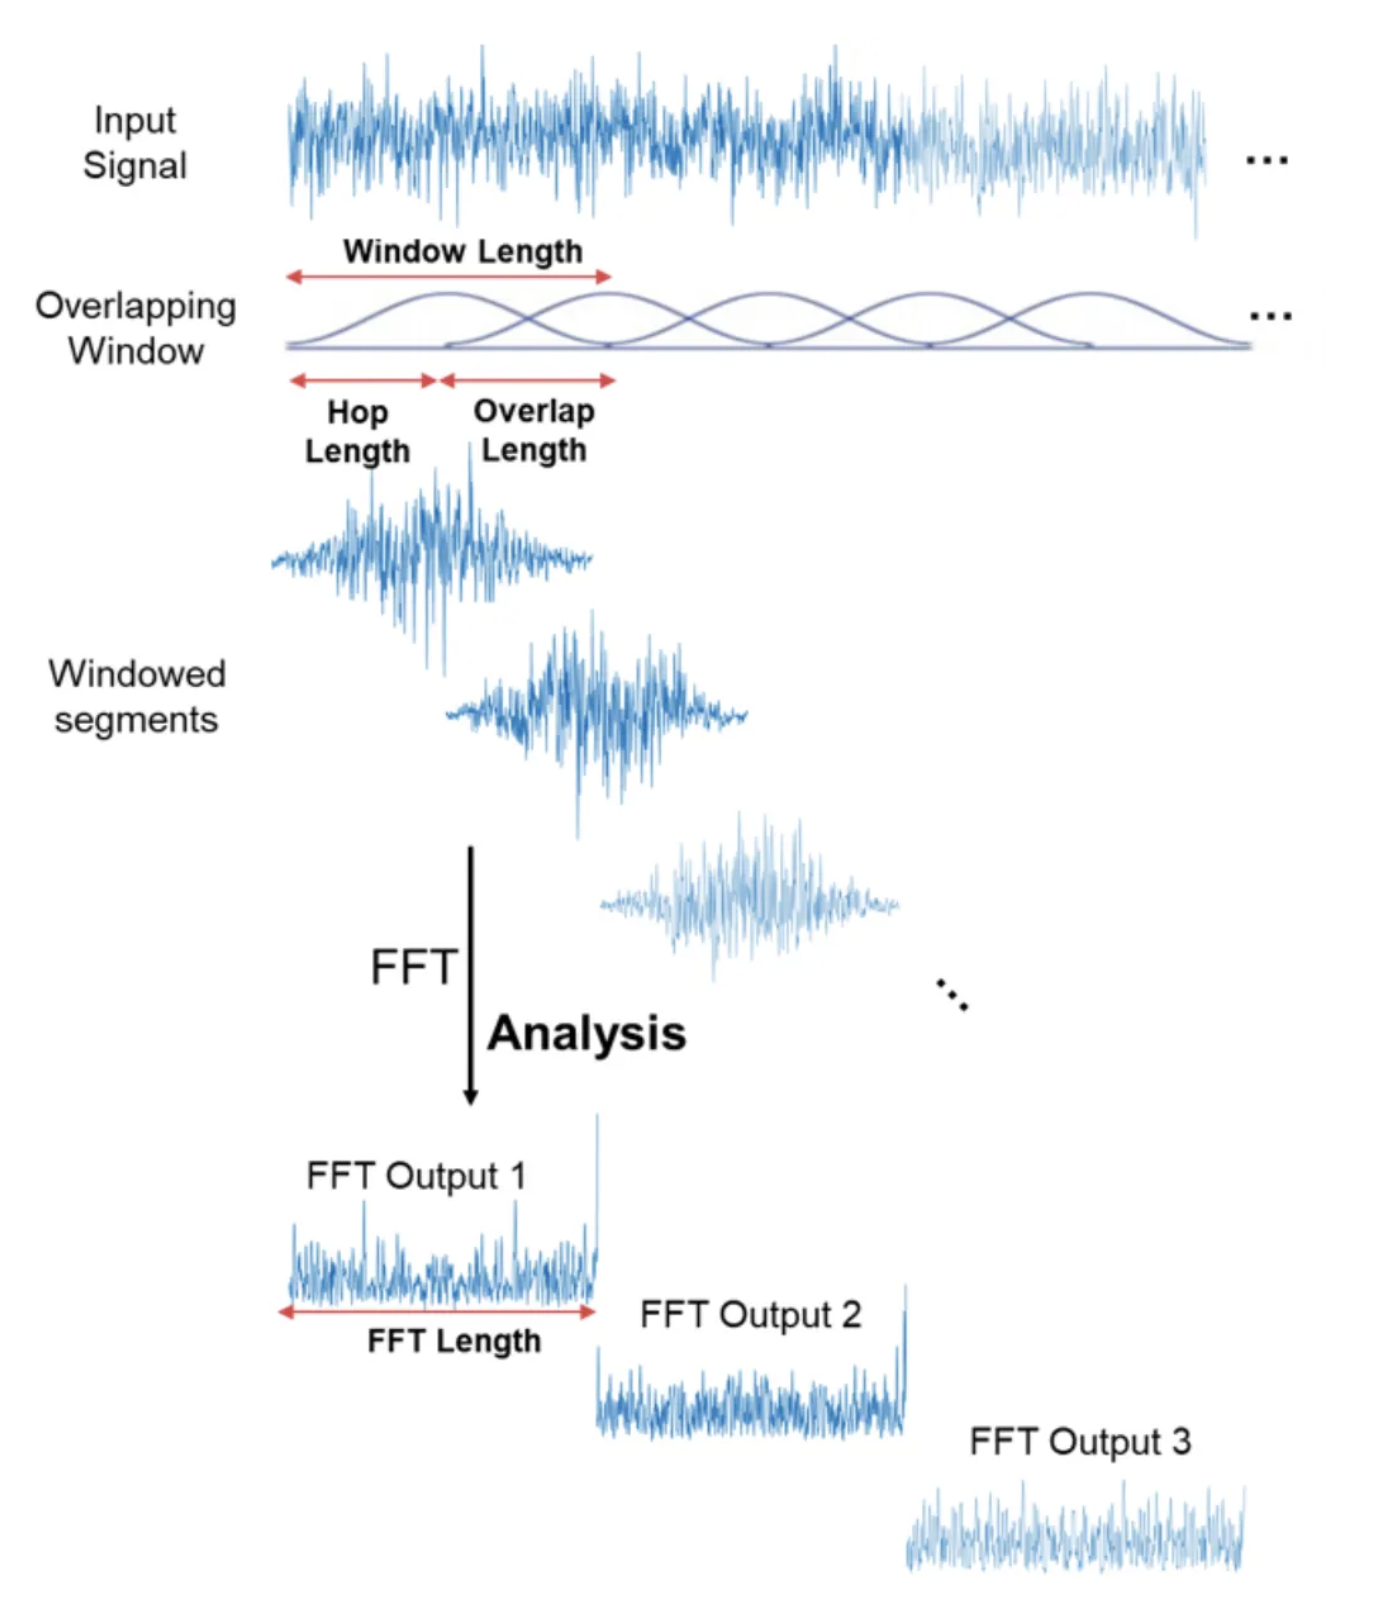

**Разбиение аудиосигнала на чанки**

In [ ]:
config = DataConfig()

mel_spec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=config.sample_rate,
    n_fft=config.n_fft,
    hop_length=config.hop_length,
    n_mels=config.n_mels,
)

index = 0
row = data.iloc[index]

audio_path = os.path.join(WORK_DIR, "golos_farfield_val", row["path"])
waveform, _ = torchaudio.load(audio_path)
print("Duration:", row["duration"])
waveform = waveform[0]
print("Waveform shape:", waveform.shape)
mel_spec = mel_spec_transform(waveform)
print("Mel spec shape:", mel_spec.shape)

Duration: 6.2828125
Waveform shape: torch.Size([100525])
Mel spec shape: torch.Size([64, 629])


In [ ]:
chunks = []
total = mel_spec.shape[1]
for start in range(0, total, config.stride):
    chunk = mel_spec[:, start : start + config.stride]  # [n_mels, stride]
    chunk = chunk.flatten()  # [n_mels * stride]

    if chunk.shape[0] < config.stride * config.n_mels:
        chunk = torch.cat(
            [chunk, torch.zeros(config.stride * config.n_mels - chunk.shape[0])]
        )

    chunks.append(chunk)

chunks = torch.stack(chunks, dim=0)
print("Chunks shape:", chunks.shape)
print("Duration:", row["duration"])

Chunks shape: torch.Size([63, 640])
Duration: 6.2828125


**Реализация класса данных**

In [ ]:
class EndOfUtteranceDataset(Dataset):
    def __init__(self, dataset_path: str, config: DataConfig):
        self.config = config
        self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.config.sample_rate,
            n_fft=self.config.n_fft,
            hop_length=self.config.hop_length,
            n_mels=self.config.n_mels,
        )

        self.load_data(dataset_path)

    def load_data(self, dataset_path: str):
        required_cols = ["hash_id", "transcription", "path", "eou_target"]
        data = pd.read_csv(f"{dataset_path}/dataset.tsv", sep="\t")

        missing_cols = set(required_cols) - set(data.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        initial_len = len(data)
        data = data.dropna(subset=required_cols)
        if len(data) < initial_len:
            print(
                f"Warning: Dropped {initial_len - len(data)} rows with missing values"
            )

        self.hash_ids = data["hash_id"].tolist()
        self.paths = [os.path.join(dataset_path, path) for path in data["path"]]
        self.transcriptions = data["transcription"].tolist()
        self.eou_targets = (data["eou_target"] * 1000).tolist()  # sec -> ms

    def __len__(self):
        return len(self.hash_ids)

    def load_audio(self, path: str):
        try:
            waveform, sr = torchaudio.load(path)
        except Exception as e:
            raise RuntimeError(f"Failed to load audio from {path}: {e}") from e
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sr != self.config.sample_rate:
            waveform = torchaudio.functional.resample(
                waveform, sr, self.config.sample_rate
            )
        return waveform[0]

    def create_features(self, mel_spec: torch.Tensor):
        chunks = []
        total = mel_spec.shape[1]
        chunk_features_size = self.config.stride * self.config.n_mels
        for start in range(0, total, self.config.stride):
            chunk = mel_spec[:, start : start + self.config.stride]  # [n_mels, stride]
            chunk = chunk.flatten()  # [n_mels * stride]

            if chunk.shape[0] < chunk_features_size:
                padding_size = chunk_features_size - chunk.shape[0]
                chunk = torch.cat([chunk, torch.zeros(padding_size)], dim=0)

            chunks.append(chunk)

        chunks = torch.stack(chunks, dim=0)
        return chunks

    def create_labels(self, num_chunks: int, target_time: float):
        labels = torch.zeros(num_chunks, dtype=torch.float32) # [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        if target_time > 0:
            target_idx = min(int(target_time / self.config.chunk_size), num_chunks - 1)
            labels[target_idx:] = 1.0  # [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
        return labels

    def __getitem__(self, idx: int):
        hash_id = self.hash_ids[idx]
        path = self.paths[idx]
        transcription = self.transcriptions[idx]
        eou_target = self.eou_targets[idx]

        waveform = self.load_audio(path)
        mel_spec = self.mel_spec_transform(waveform)  # [n_mels, time_frames]
        if mel_spec.numel() == 0:
            raise ValueError(f"Empty mel spectrogram for {path}")
        mel_spec = torch.log(mel_spec + 1e-9)

        features = self.create_features(mel_spec)  # [n_chunks, n_mels * stride]
        labels = self.create_labels(features.shape[0], eou_target)  # [n_chunks]

        return {
            "features": features,
            "labels": labels,
            "eou_target": eou_target,
            "transcription": transcription,
            "path": path,
            "hash_id": hash_id,
        }

**Реализация класса модели**

В качестве baseline рассмотрим простую архитектуру модели, в основе которой будет однонаправленная LSTM.

In [ ]:
class EndOfUtteranceModel(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 128,
        num_layers: int = 2,
        batch_first: bool = True,
        bidirectional: bool = False,
        dropout: float = 0.2
    ):
        super().__init__()
        self.feature_proj = nn.Linear(input_dim, hidden_dim)

        self.rnn = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=bidirectional,
            dropout=dropout
        )

        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_proj(x)
        out, _ = self.rnn(x)
        logits = self.head(out).squeeze(-1)
        return logits

**Реализация collate function**

Переопределим collate function для корректно обучения с batch size > 1.

In [ ]:
def collate_fn(batch):
    features = [elem["features"] for elem in batch]
    labels = [elem["labels"] for elem in batch]

    features_mask = [torch.ones(f.shape[0]) for f in features]
    labels_lens = [l.shape[0] for l in labels]

    features_pad = torch.nn.utils.rnn.pad_sequence(
        features, batch_first=True, padding_value=0
    )
    features_mask_pad = torch.nn.utils.rnn.pad_sequence(
        features_mask, batch_first=True, padding_value=0
    )
    labels_pad = torch.nn.utils.rnn.pad_sequence(
        labels, batch_first=True, padding_value=0
    )

    metadata = {
        "eou_targets": [elem["eou_target"] for elem in batch],
        "transcriptions": [elem["transcription"] for elem in batch],
        "paths": [elem["path"] for elem in batch],
        "hash_ids": [elem["hash_id"] for elem in batch],
    }

    return {
        "features": features_pad,
        "features_mask": features_mask_pad,
        "labels": labels_pad,
        "labels_lens": labels_lens,
        **metadata,
    }

**Реализация подсчета метрик**

In [ ]:
def calc_metrics(predictions, lengths, labels, threshold):
    prediction_labels_list, target_labels_list = [], []

    for pred, label, length in zip(predictions, labels, lengths):
        prediction_labels_list.extend(pred[:length])
        target_labels_list.extend(label[:length])

    prediction_labels_list = np.array(prediction_labels_list)
    target_labels_list = np.array(target_labels_list)

    prediction_labels_list = prediction_labels_list > threshold

    precision = precision_score(
        target_labels_list, prediction_labels_list, zero_division=0
    )
    recall = recall_score(target_labels_list, prediction_labels_list, zero_division=0)
    f1 = f1_score(target_labels_list, prediction_labels_list, zero_division=0)

    return precision, recall, f1

**Реализация пайплайна обучения модели**

In [ ]:
class Trainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        device="cpu",
        epochs=15,
        lr=1e-4,
        min_lr=1e-6,
        threshold=0.5,
        log_dir="logs",
    ):
        self.device = device
        self.model = model.to(self.device)

        self.train_loader = train_loader
        self.val_loader = val_loader

        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=epochs, eta_min=min_lr)
        self.criterion = nn.BCELoss()

        self.log_dir = log_dir
        self.writer = SummaryWriter(log_dir=self.log_dir)

        self.epochs = epochs
        self.threshold = threshold
        self.best_f1 = 0.0

    def step(self, batch, train=True):
        features, labels = batch["features"].to(self.device), batch["labels"].to(
            self.device
        )
        predictions = self.model(features)
        predictions = predictions * batch["features_mask"].to(self.device)

        loss = self.criterion(predictions, labels)
        if train:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss, predictions, labels

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        for batch in self.train_loader:
            loss, _, _ = self.step(batch, train=True)
            total_loss += loss.item()
        avg_loss = total_loss / len(self.train_loader)
        self.writer.add_scalar('train/loss', avg_loss, epoch)
        print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f}")
        return avg_loss

    def validate(self, epoch):
        self.model.eval()
        total_loss = 0
        predictions, lengths, target_labels = [], [], []
        with torch.no_grad():
            for batch in self.val_loader:
                loss, preds, labels = self.step(batch, train=False)
                total_loss += loss.item()

                predictions.extend(preds.detach().cpu().numpy())
                lengths.extend(batch["labels_lens"])
                target_labels.extend(labels.detach().cpu().numpy())

        avg_loss = total_loss / len(self.val_loader)
        precision, recall, f1 = calc_metrics(
            predictions, lengths, target_labels, self.threshold
        )

        lr = self.optimizer.param_groups[0]["lr"]

        metrics = {
            'loss': avg_loss,
            'learning_rate': lr,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'eou_threshold': self.threshold,
        }
        for name, value in metrics.items():
            self.writer.add_scalar(f'val/{name}', value, epoch)

        print(
            f"Val | Loss: {avg_loss:.4f} | P: {precision:.3f} | R: {recall:.3f} | F1: {f1:.3f} | LR: {lr:.8f}"
        )

        if f1 > self.best_f1:
            self.best_f1 = f1
            ckpt_path = os.path.join(self.log_dir, "best_model.pt")
            checkpoint = {
                "model_state": self.model.state_dict(),
                "optimizer_state": self.optimizer.state_dict(),
                "scheduler_state": self.scheduler.state_dict(),
                "epoch": epoch,
                "f1": f1,
                "threshold": self.threshold,
                "config": self.config.__dict__ if hasattr(self, "config") else None,
            }
            torch.save(checkpoint, ckpt_path)
            print(f"✅ New best checkpoint: {ckpt_path} (F1={f1:.3f})")

        return avg_loss

    def fit(self):
        for epoch in range(self.epochs):
            self.train_epoch(epoch)
            self.validate(epoch)
            self.scheduler.step()

**Baseline**

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5
DEVICE = "cuda:0"
INPUT_DIM = 640

config = DataConfig()

train_ds = EndOfUtteranceDataset(f"{WORK_DIR}/golos_farfield_train", config)
val_ds = EndOfUtteranceDataset(f"{WORK_DIR}/golos_farfield_val", config)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
model = EndOfUtteranceModel(input_dim=INPUT_DIM)

log_dir = f"{WORK_DIR}/runs/end_of_query_baseline/"
os.makedirs(log_dir, exist_ok=True)
torch.save(model, os.path.join(log_dir, "base_model.pt"))

In [ ]:
trainer = Trainer(
    model, train_loader, val_loader, device=DEVICE, epochs=EPOCHS, log_dir=log_dir
)
trainer.fit()

Epoch 0 | Train Loss: 0.1936
Val | Loss: 0.0979 | P: 0.909 | R: 0.859 | F1: 0.883 | LR: 0.00010000
✅ New best checkpoint: /content/runs/end_of_query_baseline/best_model.pt (F1=0.883)
Epoch 1 | Train Loss: 0.0816
Val | Loss: 0.0884 | P: 0.899 | R: 0.883 | F1: 0.891 | LR: 0.00009055
✅ New best checkpoint: /content/runs/end_of_query_baseline/best_model.pt (F1=0.891)
Epoch 2 | Train Loss: 0.0729
Val | Loss: 0.0754 | P: 0.929 | R: 0.888 | F1: 0.908 | LR: 0.00006580
✅ New best checkpoint: /content/runs/end_of_query_baseline/best_model.pt (F1=0.908)
Epoch 3 | Train Loss: 0.0678
Val | Loss: 0.0746 | P: 0.895 | R: 0.921 | F1: 0.908 | LR: 0.00003520
✅ New best checkpoint: /content/runs/end_of_query_baseline/best_model.pt (F1=0.908)
Epoch 4 | Train Loss: 0.0658
Val | Loss: 0.0717 | P: 0.910 | R: 0.914 | F1: 0.912 | LR: 0.00001045
✅ New best checkpoint: /content/runs/end_of_query_baseline/best_model.pt (F1=0.912)


**Сравнение моделей до / после обучения**

In [ ]:
base_model = torch.load(
    os.path.join(log_dir, "base_model.pt"),
    weights_only=False,
    map_location=DEVICE,
)
base_model.eval()
base_model.to(DEVICE)

best_model = EndOfUtteranceModel(input_dim=INPUT_DIM)
best_model.load_state_dict(
    torch.load(
        os.path.join(log_dir, "best_model.pt"),
        weights_only=False,
        map_location=DEVICE,
    )["model_state"]
)
best_model.eval()
best_model.to(DEVICE)

EndOfUtteranceModel(
  (feature_proj): Linear(in_features=640, out_features=128, bias=True)
  (rnn): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
def get_predictions(model, dataloader, threshold, device, chunk_size):
    model.to(device)
    model.eval()

    predictions = {}
    with torch.no_grad():
        for batch in dataloader:
            features, _ = batch["features"].to(device), batch["labels"].to(device)
            outputs = model(features)

            for i, length in enumerate(batch["labels_lens"]):
                probabilities = outputs[i, :length].detach().cpu().numpy()
                prediction_labels = probabilities > threshold
                prediction = prediction_labels.argmax()
                prediction = prediction * chunk_size + chunk_size

                predictions[batch["hash_ids"][i]] = prediction.item()

    return predictions

In [ ]:
best_model_predictions = get_predictions(
    model=best_model,
    dataloader=val_loader,
    threshold=0.5,
    device=DEVICE,
    chunk_size=config.chunk_size,
)

In [ ]:
import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio

def eou_plot(this_model, that_model, that_model_prediction, sample, device):
    this_model.to(device)
    that_model.to(device)
    hash_id = sample["hash_id"]

    wave, sr = librosa.load(sample["path"], sr=None)
    max_val = np.max(np.abs(wave))
    if max_val > 0:
        wave = wave / max_val

    duration_ms = len(wave) / sr * 1000
    times = np.linspace(0, duration_ms, num=len(wave))

    this_model_predictions = (
        this_model(sample["features"].to(device)).detach().cpu().numpy()
    )
    that_model_predictions = (
        that_model(sample["features"].to(device)).detach().cpu().numpy()
    )
    times_predictions = [i * 100 for i in range(1, len(that_model_predictions) + 1)]

    eou_target = sample["eou_target"]
    eou_predict = that_model_prediction[hash_id]

    plt.figure(figsize=(16, 6))
    plt.plot(times, wave)

    plt.plot(
        times_predictions,
        this_model_predictions,
        marker="o",
        linestyle="-",
        label="This model EOU predictions",
    )
    plt.plot(
        times_predictions,
        that_model_predictions,
        marker="o",
        linestyle="-",
        label="That model EOU predictions",
    )
    plt.axvline(
        x=eou_target,
        ymin=-1.1,
        ymax=1.1,
        linestyle="--",
        label="Target EOU",
        linewidth=3,
    )
    plt.axvline(
        x=eou_predict,
        ymin=-1.1,
        ymax=1.1,
        linestyle="--",
        label="Prediction EOU",
        linewidth=3,
        color="r",
    )

    plt.title(f'Transcription: {sample["transcription"]}')
    plt.xlabel("Time, ms")
    plt.ylabel("Amplitude / Predictions")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

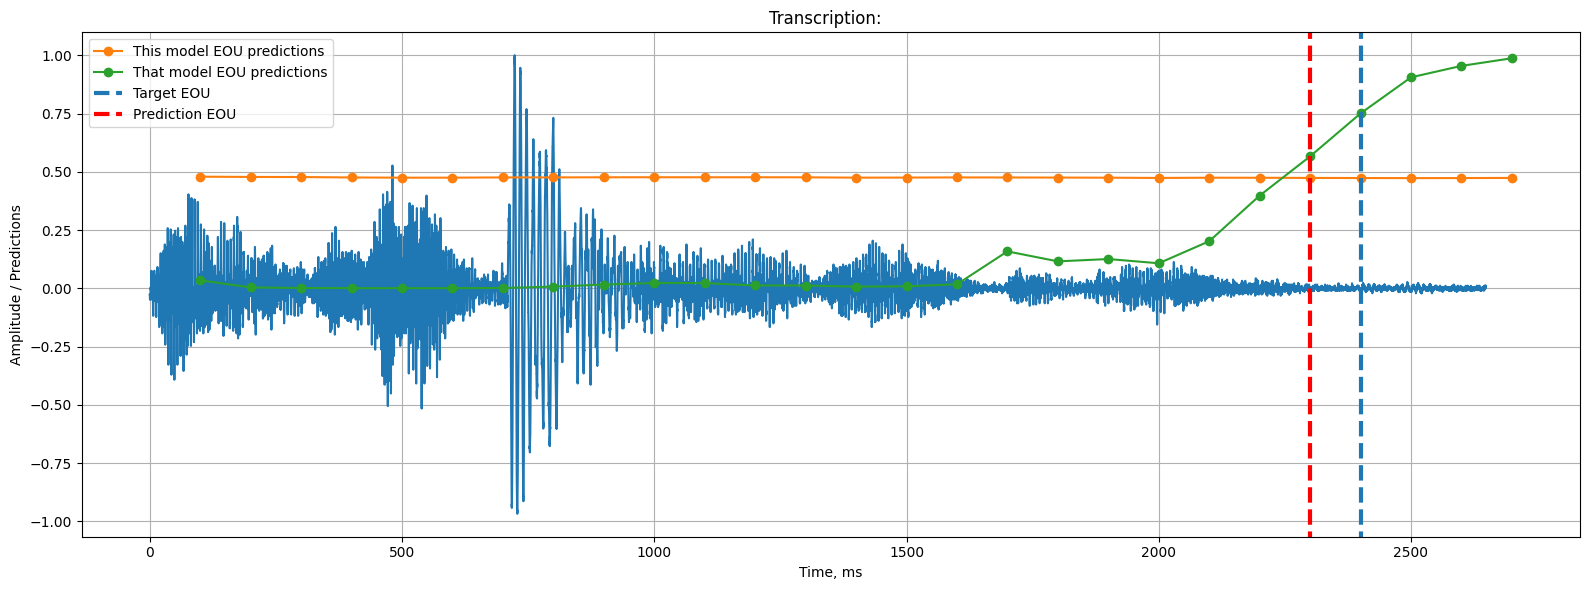

In [ ]:
index = 1000
sample = val_ds[index]

eou_plot(base_model, best_model, best_model_predictions, sample, device=DEVICE)
Audio(sample["path"])

 **Посмотрим на краевые случаи**

In [ ]:
eou_distance = []

for i, elem in enumerate(val_ds):
    eou_target = elem["eou_target"]
    eou_predict = best_model_predictions[elem["hash_id"]]
    eou_distance.append(eou_predict - eou_target)

top_pos_indices = sorted(range(len(eou_distance)), key=lambda i: eou_distance[i], reverse=True)[:5]
top_neg_indices = sorted(range(len(eou_distance)), key=lambda i: eou_distance[i])[:5]

In [ ]:
print("More latency idx:", top_pos_indices)
print("Early stoppings idx:", top_neg_indices)

More latency idx: [1714, 673, 60, 1243, 1777]
Early stoppings idx: [155, 290, 601, 1799, 207]


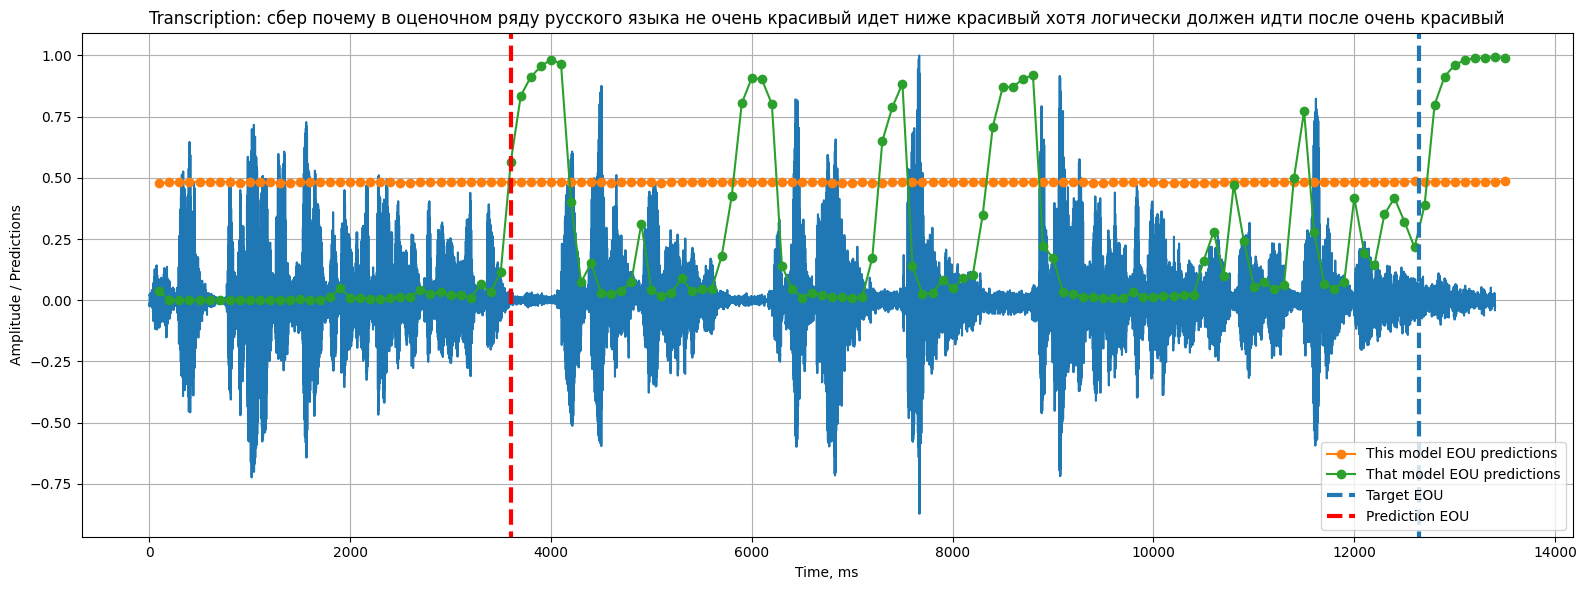

In [ ]:
index = 155
sample = val_ds[index]

eou_plot(base_model, best_model, best_model_predictions, sample, device=DEVICE)
Audio(sample["path"])

### Домашнее задание

- **Реализация метрики EOU latency - 2 балла**
    - Определить EOU threshold для заданного допустимого значения ранних срабатываний. В нашем случае - 5%
    - По найденному порогу подсчет EOU distance = prediction eou - target eou
    - Для значений EOU distance > 0 подсчет avg, q50, q75, q90, q99

- **Реализация Causal Transformer - 2 балла**
    - Контекст - текущий и предыдущие чанки

- **Соревнование**
    - Обучить модель (в основе lstm или causal transformer)
    - Подготовить предсказания на test данных, отправить на kaggle
    - Метрика - MAE
    - Ограничения:
        - Контекст - текущий и предыдущие чанки
        - Число параметров - 2млн
    - **Баллы:**
        - Топ 10% - 5 баллов
        - Топ 20% - 4 балла
        - Топ 30% - 3 балла
        - Топ 40% - 2 балла
        - Побить baseline - 1 балл

- **Выводы - 1 балл**
    - Подготовить ответы на вопросы и рассказать про эксперименты

- **Дополнительное задание - 1 балл**
    - Сравнение качества распознавания модели GigaAM-v3_ctc без и с EOU моделью

### 1. Реализация EOU latency

In [ ]:
def calc_early_stoppings_threshold(predictions, labels, early_stoppings=5):
    # =========== YOUR CODE HERE ===========

def calc_eou_latency_metrics(predictions, lengths, eou_targets, threshold):
    # =========== YOUR CODE HERE ===========

In [ ]:
class Trainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        device="cpu",
        epochs=15,
        lr=1e-4,
        min_lr=1e-6,
        threshold=0.5,
        log_dir="logs",
        early_stopping=5,
        percentiles=[50, 75, 90, 99],
    ):
        self.device = device
        self.model = model.to(self.device)

        self.train_loader = train_loader
        self.val_loader = val_loader

        # =========== YOUR CODE HERE ===========
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=epochs, eta_min=min_lr)
        self.criterion = nn.BCELoss()
        # =========== YOUR CODE HERE ===========

        self.log_dir = log_dir
        self.writer = SummaryWriter(log_dir=self.log_dir)

        self.epochs = epochs
        # =========== YOUR CODE HERE ===========
        self.early_stopping = early_stopping
        self.early_stoppings_threshold = threshold
        self.percentiles = percentiles
        # ...
        # =========== YOUR CODE HERE ===========

    def step(self, batch, train=True):
        features, labels = batch["features"].to(self.device), batch["labels"].to(
            self.device
        )
        predictions = self.model(features)
        predictions = predictions * batch["features_mask"].to(self.device)

        loss = self.criterion(predictions, labels)
        if train:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss, predictions, labels

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        for batch in self.train_loader:
            loss, _, _ = self.step(batch, train=True)
            total_loss += loss.item()
        avg_loss = total_loss / len(self.train_loader)
        self.writer.add_scalar('train/loss', avg_loss, epoch)
        print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f}")
        return avg_loss

    def validate(self, epoch):
        self.model.eval()
        total_loss = 0
        predictions, lengths, target_labels, eou_targets = [], [], [], []
        with torch.no_grad():
            for batch in self.val_loader:
                loss, preds, labels = self.step(batch, train=False)
                total_loss += loss.item()

                # =========== YOUR CODE HERE ===========
                # =========== YOUR CODE HERE ===========

        avg_loss = total_loss / len(self.val_loader)

        # =========== YOUR CODE HERE ===========
        # eou_latency = ...
        # =========== YOUR CODE HERE ===========

        avg_eou_latency = np.mean(eou_latency)
        eou_percentiles = {
            f"eou_latency_q{p}": np.percentile(eou_latency, p) for p in self.percentiles
        }
        precision, recall, f1 = calc_metrics(
            predictions, lengths, target_labels, self.early_stoppings_threshold
        )

        lr = self.optimizer.param_groups[0]["lr"]

        metrics = {
            "loss": avg_loss,
            "learning_rate": lr,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "eou_threshold": self.early_stoppings_threshold,
            "eou_latency_avg": avg_eou_latency,
            **eou_percentiles,
        }
        for name, value in metrics.items():
            self.writer.add_scalar(f"val/{name}", value, epoch)

        print(
            f"Val | Loss: {avg_loss:.4f} | P: {precision:.3f} | R: {recall:.3f} | F1: {f1:.3f} | LR: {lr:.8f}\n"
            f"EOU threshold: {self.early_stoppings_threshold:.4f}\n"
            f"EOU AVG: {avg_eou_latency:.3f} | EOU Q50: {eou_percentiles['eou_latency_q50']:.3f} | EOU Q75: {eou_percentiles['eou_latency_q75']:.3f} |"
            f"EOU Q90: {eou_percentiles['eou_latency_q90']:.3f} | EOU Q99: {eou_percentiles['eou_latency_q99']:.3f}"
        )

        # =========== YOUR CODE HERE ===========
        # save best ckpt
        # =========== YOUR CODE HERE ===========

        return avg_loss

    def fit(self):
        for epoch in range(self.epochs):
            self.train_epoch(epoch)
            self.validate(epoch)
            self.scheduler.step()

**Проверки:**

In [ ]:
def inference(model, dataloader, threshold, device):
    # =========== YOUR CODE HERE ===========
    # return eou_latency, precision, recall, f1

Выгружаем заранее обученную модель для проверки корректности подсчета метрик

In [ ]:
!gdown --id 1BwKFHm7D8MzNbVpMAhyvm_Irl6eD3TCP -O baseline_model.pt

In [ ]:
baseline_model = EndOfUtteranceModel(input_dim=INPUT_DIM)
baseline_model_ckpt = torch.load(
    f"{WORK_DIR}/baseline_model.pt",
    weights_only=False,
    map_location=DEVICE,
)
baseline_model_threshold = baseline_model_ckpt["threshold"]
baseline_model.load_state_dict(baseline_model_ckpt["model_state"])
baseline_model.eval()
baseline_model.to(DEVICE)


In [ ]:
total_params = sum(p.numel() for p in best_model.parameters())

In [ ]:
eou_latency, precision, recall, f1 = inference(baseline_model, val_loader, baseline_model_threshold, DEVICE)

In [ ]:
assert total_params == 354561
assert abs(np.mean(eou_latency) - 347) < 1
assert abs(np.percentile(eou_latency, 50) - 320) < 1
assert abs(np.percentile(eou_latency, 75) - 420) < 1
assert abs(np.percentile(eou_latency, 90) - 540) < 1
assert abs(np.percentile(eou_latency, 99) - 900) < 1

print("✅ 2 point!")

### 2. Реализация Causal Transformer

In [ ]:
class EndOfUtteranceCausalTransformerModel(nn.Module):
    # =========== YOUR CODE HERE ===========
    # =========== YOUR CODE HERE ===========

In [ ]:
model_transformer = EndOfUtteranceCausalTransformerModel(input_dim=INPUT_DIM)

log_dir = f"{WORK_DIR}/runs/end_of_query_causal_transformer/"
os.makedirs(log_dir, exist_ok=True)
model_path = os.path.join(log_dir, "base_model.pt")
torch.save(model, model_path)

In [ ]:
trainer = Trainer(
    model_transformer, train_loader, val_loader, device=DEVICE, epochs=EPOCHS, log_dir=log_dir
)
trainer.fit()

**Проверки**

In [ ]:
best_model_transformer = EndOfUtteranceCausalTransformerModel(input_dim=INPUT_DIM)
best_model_transformer_ckpt = torch.load(
    f"{WORK_DIR}/runs/end_of_query_causal_transformer/best_model.pt",
    weights_only=False,
    map_location=DEVICE,
)
best_model_transformer_threshold = best_model_transformer_ckpt["threshold"]
best_model_transformer.load_state_dict(best_model_transformer_ckpt["model_state"])
best_model_transformer.eval()
best_model_transformer.to(DEVICE)

In [ ]:
total_params = sum(p.numel() for p in best_model_transformer.parameters())

In [ ]:
elem = val_ds[0]
features = elem["features"]
features = torch.unsqueeze(features, 0)
features_crop = features[:, :10, :]

In [ ]:
predictions_full = best_model_transformer(features.to(DEVICE)).detach().cpu()
predictions_crop = best_model_transformer(features_crop.to(DEVICE)).detach().cpu()

In [ ]:
assert total_params < 2000000
assert sum(predictions_crop[0] - predictions_full[0, :10]).item() < 1e-6

print("✅ 2 point!")

### 3. Соревнование

In [ ]:
data = pd.read_csv(f"{WORK_DIR}/golos_farfield_test/dataset.tsv", sep="\t")
data.head()

,id,path,transcription,duration,transcription_ru,transcription_unnorm,hash_id,eou_target
0,58b586f67f5e634506e215df5996b82e,files/58b586f67f5e634506e215df5996b82e.wav,джой хватит,1.696625,джой хватит,джой хватит,58b586f67f5e634506e215df5996b82e,1.696625
1,26093ef7a8c5ec6a3c586a6a929c1bd3,files/26093ef7a8c5ec6a3c586a6a929c1bd3.wav,салют вызов светлане васильевне николенко,3.172063,салют вызов светлане васильевне николенко,салют вызов светлане васильевне николенко,26093ef7a8c5ec6a3c586a6a929c1bd3,3.172063
2,b42d13ab3dc159fac39a1120e8011f66,files/b42d13ab3dc159fac39a1120e8011f66.wav,салют хватит,1.522687,салют хватит,салют хватит,b42d13ab3dc159fac39a1120e8011f66,1.522687
3,7e55843e745a239b35212e2caba77239,files/7e55843e745a239b35212e2caba77239.wav,джой звонок юрию ивановичу царькову,3.064062,джой звонок юрию ивановичу царькову,джой звонок юрию ивановичу царькову,7e55843e745a239b35212e2caba77239,3.064062
4,a0c621e2819a3747e42d05940aab0446,files/a0c621e2819a3747e42d05940aab0446.wav,джой выйти из сценария,2.314750,джой выйти из сценария,джой выйти из сценария,a0c621e2819a3747e42d05940aab0446,2.314750


In [ ]:
best_model_transformer = EndOfUtteranceCausalTransformerModel(input_dim=INPUT_DIM)
best_model_transformer_ckpt = torch.load(
    f"{WORK_DIR}/runs/end_of_query_causal_transformer/best_model.pt",
    weights_only=False,
    map_location=DEVICE,
)
best_model_transformer_threshold = best_model_transformer_ckpt["threshold"]
best_model_transformer.load_state_dict(best_model_transformer_ckpt["model_state"])
best_model_transformer.eval()
best_model_transformer.to(DEVICE)

In [ ]:
test_ds = EndOfUtteranceDataset(f"{WORK_DIR}/golos_farfield_test", config)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [ ]:
model_predictions = get_predictions(
    model=best_model_transformer,
    dataloader=test_loader,
    threshold=best_model_transformer_threshold,
    device=DEVICE,
    chunk_size=config.chunk_size,
)

In [ ]:
solution = pd.DataFrame(
    {
        'ID': model_predictions.keys(),
        'eou': model_predictions.values(), # ms
    }
)

In [ ]:
solution.to_csv(f'{WORK_DIR}/runs/solution.csv', index=False)

### 4. Выводы

- Какую архитектуру выбрали в основу своей модели? Почему?
- Рассматривали ли другие модели оптимизации и функции потерь? Что дало лучший прирост качества в обучении модели?
- По какой метрики отбирали best checkpoint на валидации? Было ли изменение в качестве при изменении метрики?
- Какие еще эксперименты проводили? Какие результаты? (кратко)

In [ ]:
# =========== YOUR CODE HERE ===========

### 5. Дополнительное задание

[GigaAM](https://github.com/salute-developers/GigaAM) - (**Giga** **A**coustic **M**odel) is a family of open-source models for Russian speech processing tasks, including speech recognition and emotion recognition.

Необходимо сравнить качество модели (WER) GigaAM-v3-ctc до и после добавления модели EOU.

Что будем считать добавлением EOU модели:
- Получаем предсказания вашей лучшей модели EOU
- По этим предсказаниям обрезаем аудио
    - При это transcription остается без изменений
- На этих данных подсчитываем WER
- Сделать вывод по полученным результатам:
    - Какое качество у вашей модели определения конца запроса? Какой получился порог?
    - Произошли ли изменение WER после обрезки аудио по меткам конца запроса от вашей модели? На сколько? Как оцените такой результат?
    - Есть ли early stoppings? Как с ними можно бороться в production системе?

In [ ]:
# =========== YOUR CODE HERE ===========